In [49]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import sklearn.svm as svm
from sklearn.externals import joblib
import os
import sys
from sample_feature import TestFeature
import digits_functions as digits
import findspark
from datetime import datetime
import matplotlib.pyplot as plt

findspark.init(os.path.expanduser('~/model-serving/spark-1.6.0-bin-hadoop2.4'))
# findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionModel, LogisticRegressionWithSGD
from pyspark.mllib.classification import SVMModel, SVMWithSGD
from pyspark.mllib.tree import RandomForestModel

In [2]:
conf = SparkConf() \
            .setAppName("crankshaw-pyspark") \
            .set("spark.executor.memory", "2g") \
            .set("spark.kryoserializer.buffer.mb", "128") \
            .set("master", "local")
sc = SparkContext(conf=conf, batchSize=10)
digits_base = "/Users/crankshaw/model-serving/data/mnist_data"

In [3]:
def load_digits(digits_location, digits_filename = "train.data"):
    digits_path = digits_location + "/" + digits_filename
    print "Source file:", digits_path
    df = pd.read_csv(digits_path, sep=",", header=None)
    data = df.values
    print "Number of image files:", len(data)
    y = data[:,0]
    X = data[:,1:]
    return (X, y)

def load_sk_models():
    model_path = "sklearn_models"
    features = []
    for i in range(10):
        p = "%s/predict_%d_svm/predict_%d_svm.pkl" % (model_path, i, i)
        print "loading %s" % p
        features.append(joblib.load(p))
    return features

# This code normalizes x as part of the prediction, so don't normalize the test data
# ahead of time
# def get_features(features, x):
#     """
#     WORKS FOR SPARK FEATURES
#     """
#     return np.array([f.predict(x.reshape(1,-1))[0] for f in features])



def get_features(features, x):
    """
    WORKS FOR SPARK FEATURES
    """
    return np.array([float(f.predict(x)) for f in features])


def load_spark_models():
    
    base_path = "spark_models/svm_predict_%d"
    models = []
    for i in range(1,11):
        model = SVMModel.load(sc, base_path % i)
        models.append(model)
    return models

def train_tasks(tasks):
    per_task_err = []
    for i in range(len(tasks)):
#         print 'task %d' % i
        features_train = []
        for j in range(tasks[i].X.shape[0]):
            features_train.append(get_features(fs, tasks[i].X[j]))
        features_train = np.array(features_train)
        
#         clf = lm.LogisticRegression(penalty="l1", solver='liblinear', fit_intercept=False, C=1.0)
        clf = lm.LogisticRegression(penalty="l2", C=0.10, solver='liblinear')

        clf.fit(features_train, tasks[i].y)
        features_test=[]
        for j in range(tasks[i].test_X.shape[0]):
            features_test.append(get_features(fs, tasks[i].test_X[j]))
        features_test = np.array(features_test)
        predictions = clf.predict(features_test)
        err = np.sum(predictions != tasks[i].test_y)
        per_task_err.append(float(err)/float(len(predictions)))
        if i % 10 == 0:
            print np.mean(per_task_err)
    return per_task_err

In [4]:
test_x, test_y = load_digits("/Users/crankshaw/model-serving/data/mnist_data", digits_filename="test.data")
# train_x, train_y = load_digits("/Users/crankshaw/model-serving/data/mnist_data", "train.data")
fs = load_spark_models()
# print test_y[10], get_features(fs, test_x[10])
my_tasks = digits.create_mtl_datasets(test_x, test_y, nTasks=100, taskSize=30, testSize=50)

Source file: /Users/crankshaw/model-serving/data/mnist_data/test.data
Number of image files: 10000


In [39]:
errs = train_tasks(my_tasks)
print errs
print np.mean(errs)

0.2
0.161818181818
0.173333333333
0.176774193548
0.18487804878
0.186666666667
0.182950819672
0.183661971831
0.193827160494
0.190549450549
[0.2, 0.22, 0.02, 0.18, 0.18, 0.04, 0.16, 0.16, 0.06, 0.28, 0.28, 0.22, 0.2, 0.04, 0.02, 0.16, 0.28, 0.16, 0.34, 0.2, 0.24, 0.02, 0.28, 0.16, 0.12, 0.08, 0.28, 0.26, 0.12, 0.2, 0.32, 0.2, 0.22, 0.22, 0.32, 0.32, 0.16, 0.3, 0.24, 0.1, 0.02, 0.18, 0.2, 0.26, 0.08, 0.26, 0.2, 0.28, 0.14, 0.0, 0.34, 0.08, 0.22, 0.2, 0.1, 0.2, 0.2, 0.06, 0.26, 0.14, 0.18, 0.22, 0.1, 0.18, 0.16, 0.3, 0.02, 0.3, 0.22, 0.12, 0.26, 0.42, 0.28, 0.28, 0.24, 0.34, 0.08, 0.36, 0.06, 0.3, 0.3, 0.12, 0.34, 0.22, 0.08, 0.06, 0.14, 0.16, 0.16, 0.22, 0.14, 0.18, 0.08, 0.22, 0.14, 0.04, 0.14, 0.12, 0.26, 0.24]
0.1876


In [ ]:
print np.mean(errs)

In [ ]:
def get_spark_features(features, x):
    return np.array([float(f.predict(x)) for f in features])


def load_spark_models():
    conf = SparkConf() \
            .setAppName("crankshaw-pyspark") \
            .set("spark.executor.memory", "2g") \
            .set("spark.kryoserializer.buffer.mb", "128") \
            .set("master", "local")
    sc = SparkContext(conf=conf, batchSize=10)
    base_path = "spark_models/svm_predict_%d"
    models = []
    for i in range(1,11):
        model = SVMModel.load(sc, base_path % i)
        models.append(model)
    return models

### Train Spark Model

In [ ]:
def objective(x, pos_label):
    # prediction objective
    if x == pos_label:
        return 1
    else:
        return 0
    # return x

def parseData(line, obj, pos_label):
    fields = line.strip().split(',')
    return LabeledPoint(obj(int(fields[0]), pos_label), [float(v)/255.0 for v in fields[1:]])

def train_svm(pos_label):
#     conf = SparkConf() \
#         .setAppName("crankshaw-pyspark") \
#         .set("spark.executor.memory", "2g") \
#         .set("spark.kryoserializer.buffer.mb", "128") \
#         .set("master", "local")
#     sc = SparkContext(conf=conf, batchSize=10)
    print 'Parsing data'
    trainRDD = sc.textFile("/crankshaw-local/mnist/data/train_norm.data").map(lambda line: parseData(line, objective, pos_label)).cache()
    # testRDD = sc.textFile("/crankshaw-local/mnist/data/test.data").map(lambda line: parseData(line, objective)).cache()

    print 'Fitting model'

    svm = SVMWithSGD.train(trainRDD)

    path = 'spark_models/svm_predict_%d' % pos_label
    svm.save(sc, path)
    sc.stop()



## Spark Batching

In [5]:
test_x, test_y = load_digits("/Users/crankshaw/model-serving/data/mnist_data", digits_filename="test.data")
# train_x, train_y = load_digits("/Users/crankshaw/model-serving/data/mnist_data", "train.data")
fs = load_spark_models()

Source file: /Users/crankshaw/model-serving/data/mnist_data/test.data
Number of image files: 10000


In [10]:
inp = test_x[500]
%timeit fs[0].predict(inp)

The slowest run took 9.18 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.2 µs per loop


In [56]:
rf10 = RandomForestModel.load(sc, "spark_models/10rf_pred_1")
def batch(size, inp):
    start = datetime.now()
    xx = []
    for i in range(size):
        xx.append(rf10.predict(inp))
    end = datetime.now()
    return (end-start).total_seconds() * 1000

def experiment(size):
    print size
    num_trials = 500
    lats = np.array([batch(size, test_x[np.random.randint(len(test_x))]) for i in range(num_trials)])
    thrus = float(size) / lats * 1000.0
    return (np.mean(thrus), np.std(thrus))



1
10
20
30
40
50
60
70
80
90


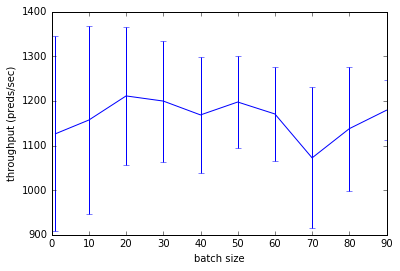

In [59]:
sizes = [1] + range(10, 100, 10)

exps = [experiment(e) for e in sizes]
(means, errs) = zip(*exps)
plt.errorbar(sizes, means, yerr=errs)
plt.xlabel("batch size")
plt.ylabel("throughput (preds/sec)")
plt.show()

In [37]:
zzz = [(1,1.5), (2, 2.5), (3,3.5), (4,4.5)]
(a,b) = zip(*zzz)

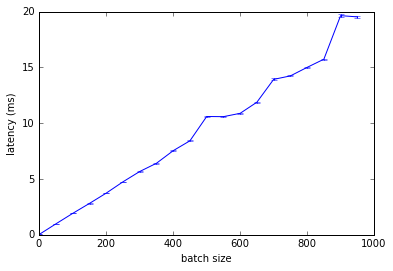

In [46]:
plt.errorbar(range(1, 1000, 50), means, yerr=errs)
plt.xlabel("batch size")
plt.ylabel("latency (ms)")
plt.show()